In [1]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import CNN2D
import torch
import pandas as pd
import pickle as pk
import pynvml
import gzip

# Introduction
My aim was to train a neural network to identify patients with Alzheimers disease based on MRI scans. This project interested me because my family has a history of Alzheimers, and because it is such a poorly understood disease. I trained a convolutional neural network on an open source MRI image dataset. I was able to achieve a high accuracy by testing many different models, acheiving an overall 98% accuracy on my test data set.

# Methods
I began by processing my dataset. I am using the Open Access Series of Imaging Studies (OASIS) dataset 1, which contains a variety of cross-sectional MRI scans of patients with and without dementia brought on by Alzheimers. Of the 400 patients in the dataset, 100 are diagnosed with dementia. I sourced the images directly from the OASIS website, https://www.oasis-brains.org/#data, and the tabular data from Kaggle https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers.

Of the MRI images in the dataset, I chose to work with those taken from the transverse plane, as they are the best at indictating white-matter loss, which is a hallmark of Alzheimers disease. The dataset also contains MRI images taken in the sagittal and coronal planes, but as mentioned these do not indicate white-matter loss effectively. The specific images I am using consist of multiple transverse plane scans which have been averaged and converted to greyscale. This makes a CNN well suited to them, as they are high contrast and have very distinct features. Unfortunately there was only one of these images per patient, making my datset relatively small.


Patient's Alzheimers diagnoses were given by the tabular data. Any patient with a Clinical Dementia Rating greater than zero had an Alzheimers diagnosis; otherwise they did not. The images were padded with zero value pixels to ensure they were square.

I chose to work with the pytorch based CNN given to the class previously. I chose pytorch specifically because it allows for easier gpu acceleration, which made training my model significantly faster. I also chose this CNN because it performed well on the MNIST digit dataset, and I assumed my dataset would pose similar challenges MNIST. As mentioned, my dataset was relatively small, at only 436 images; to try to remedy this I performed k-fold cross validation on my data. I used the function we had previously been given to generate cross validation sets, along with a function I had written to perform k-fold cross validation. By using cross validation, I was able to avoid overfitting to my training data, which was my main concern with the size of my dataset.

I ran cross validation with multiple parameter variations to acheive the best possible accuracy.

In [25]:
def pickle_images(img_dir):
    image_data = []

    for file in os.listdir(img_dir):
        image_path = os.path.join(img_dir, file)
        image = mpimg.imread(image_path)
        id = file[:13]
        image_data.append([image,id])
    image_data = pd.DataFrame(image_data, columns=['image','ID']).sort_values(by='ID')
    out_dir = img_dir + '.pk.gz'
    image_data.to_pickle(out_dir)

In [ ]:
pickle_images('voxel_images')

## Processing
To begin processing the data, I read it into a numpy array using the matplotlib image library. I also took the image ID from the file path name, which was necessary to create a target set later. I then put those images into a pandas dataframe, which I pickled in order to reduce storage size and speed up loading the data. 

In [198]:
def build_dataset(path):
    tab_data = pd.read_csv('oasis_cross-sectional.csv').sort_values(by = 'ID')
    cdr = tab_data[['CDR','ID']].fillna(0).to_numpy()
    images = pd.read_pickle(path).sort_values(by='ID')
    T = np.array([cdr[cdr[:,1] == i][0][0] for i in images['ID'].to_list()]).reshape(-1,1)
    T [ T >0 ] = 1
    X = images['image'].to_list()
    X = [np.hstack((x, np.zeros((208,32)))) for x in X]
    X = np.reshape(X,(-1,1,208,208))
    return X,T, tab_data
    

0: no Alzheimers disease


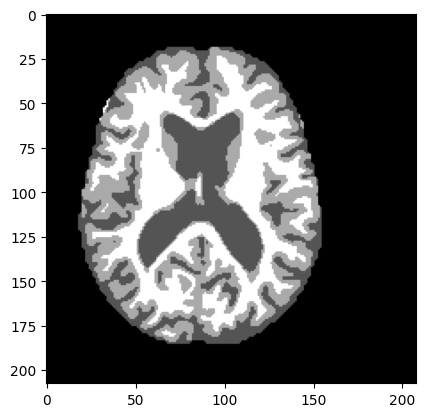

In [257]:
X, T, tab_data = build_dataset('voxel_images.pk.gz')
plt.imshow(X[0,0], cmap='gray')
print(f'{int(T[0,0])}: no Alzheimers disease')

## Processing
An example image can be seen here. This is of a patient that does not have dementia.

In [87]:
device = 'cpu'
torch.cuda.list_gpu_processes()
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cuda:0


In [92]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

In [93]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [227]:

def run_k_fold_cross_validation(X, T, n_folds, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 
                                patch_size_per_conv_layer,stride_per_conv_layer, 
                                batch_size, n_epochs, learning_rate, act_func, grid_search = False):

      results = []

      confs = []

      mis_label = []


      for n_convs, patch, stride, n_fc in \
            zip(n_hiddens_per_conv_layer,patch_size_per_conv_layer,stride_per_conv_layer,n_hiddens_per_fc_layer):
            means = []
            cnnet = CNN2D.CNN2D(208*208, n_convs, n_fc, len(np.unique(T)), 
                  patch, stride, device=device)
            pred = []; actual = []
            for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest\
                  in generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):
                  cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, 
                              learning_rate, method =act_func, verbose=False)
                  TrClasses, _ = cnnet.use(Xtrain); VClasses,_ = cnnet.use(Xvalidate)
                  TClasses, _ = cnnet.use(Xtest)
                  wrong = Xtest[TClasses != Ttest]; correct = Ttest[TClasses != Ttest]
                  label = TClasses[TClasses != Ttest]
                  mis_label.extend([wrong,correct,label])
                  means.append([100 * np.mean(TrClasses == Ttrain), 
                                    100 * np.mean(VClasses == Tvalidate), 100 * np.mean(TClasses == Ttest)])
                  pred = np.concatenate((pred,VClasses,TClasses), axis = None)
                  actual = np.concatenate((actual,Tvalidate,Ttest),axis = None)
            means = np.mean(means,axis=0)
            results.append([n_convs,patch,stride,n_fc,means[0], means[1], means[2]])
            confs.append(confusion_matrix(pred,actual))
            
      results = pd.DataFrame(results, 
                          columns=('n_conv','patch','stride','n_fc', 
                          'Train Acc', 'Val Acc', 'Test Acc'))
      return results, confs, mis_label
#print(f'Test accuracy in percent correct: {perc_correct:.2f}')


## Intermediate results
I was able to achieve a fairly high accuracy with my initial parameter choices; this may be because the dataset is relavitely skewed, which would allow a majority classifier to acheive approximately 75% accuracy. I initally began with no fully connected layers in my model, using only convolutional layers instead. The relatively large patch size is due to the size of the images in the data set; at 208*208 they require a larger stride. The number of epochs was kept lower to prevent overfitting, which is also why the learning rate is relatively fast. 6 folds was chosen to compensenate for the size of the dataset.

In [17]:
n_hiddens_per_conv_layer = [[5],[10,10],[20,5,5]]
patch_size_per_conv_layer = [[40],[25,10],[10,5,5]]
stride_per_conv_layer=[[20],[20,5],[5,5,5]]
n_hiddens_per_fc_layer = [[],[],[]]

n_epochs = 20
batch_size = 20
learning_rate = 0.01

n_folds = 6


results1, conf, wr = run_k_fold_cross_validation(X,T,n_folds,n_hiddens_per_conv_layer,
                                      n_hiddens_per_fc_layer,patch_size_per_conv_layer,
                                      stride_per_conv_layer,batch_size,n_epochs,learning_rate,act_func='tanh')
results1


,n_conv,patch,stride,n_fc,Train Acc,Val Acc,Test Acc
0,[5],[40],[20],[],99.287435,93.076725,96.323879
1,"[10, 10]","[25, 10]","[20, 5]",[],99.253897,95.084571,96.786932
2,"[20, 5, 5]","[10, 5, 5]","[5, 5, 5]",[],98.955912,93.303749,95.503248


## Intermediate Results
The first run produced high accuracies accross the train, validation and test sets. The loss between the training and test and validation sets indicate overfitting, however. The architecture with the best test accuracy was chosen to be used for further experiments.

In [19]:
n_hiddens_per_conv_layer = [[5], [5], [10,10], [10,10]]
n_hiddens_per_fc_layer =[[],[],[],[]]
stride_per_conv_layer = [[10],[20],[10,5],[5,5]]
patch_size_per_conv_layer = [[40],[20],[20,10],[25,5]]
n_epochs = 20
batch_size = 20
learning_rate = .001

n_folds = 6

results2, conf, wr = run_k_fold_cross_validation(X,T,n_folds,n_hiddens_per_conv_layer,
                                      n_hiddens_per_fc_layer,patch_size_per_conv_layer,
                                      stride_per_conv_layer,batch_size,n_epochs,learning_rate,'tanh')
results2


,n_conv,patch,stride,n_fc,Train Acc,Val Acc,Test Acc
0,[5],[40],[10],[],99.161628,96.743842,98.116278
1,[5],[20],[20],[],99.770745,96.575342,98.082192
2,"[10, 10]","[20, 10]","[10, 5]",[],99.563848,95.838318,98.030098
3,"[10, 10]","[25, 5]","[5, 5]",[],99.758621,95.701331,98.258409


In [20]:
n_hiddens_per_conv_layer = [[10,10], [10,10], [10,10]]
n_hiddens_per_fc_layer =[[],[2],[5]]
stride_per_conv_layer = [[5,5],[5,5],[5,5]]
patch_size_per_conv_layer = [[25,5],[25,5],[25,5]]
n_epochs = 20
batch_size = 20
learning_rate = .001

n_folds = 6

results3, conf, wr = run_k_fold_cross_validation(X,T,n_folds,n_hiddens_per_conv_layer,
                                      n_hiddens_per_fc_layer,patch_size_per_conv_layer,
                                      stride_per_conv_layer,batch_size,n_epochs,learning_rate,'tanh')
results3

,n_conv,patch,stride,n_fc,Train Acc,Val Acc,Test Acc
0,"[10, 10]","[25, 5]","[5, 5]",[],99.793733,95.433790,98.173516
1,"[10, 10]","[25, 5]","[5, 5]",[2],99.609668,96.340601,98.073188
2,"[10, 10]","[25, 5]","[5, 5]",[5],99.540781,96.523249,98.392823


In [229]:
n_hiddens_per_conv_layer = [[10,10]]
n_hiddens_per_fc_layer =[[5]]
stride_per_conv_layer = [[5,5]]
patch_size_per_conv_layer = [[25,5]]
n_epochs = 20
batch_size = 20
learning_rate = .001
n_folds = 6

best, conf, wr = run_k_fold_cross_validation(X,T,n_folds,n_hiddens_per_conv_layer,
                                      n_hiddens_per_fc_layer,patch_size_per_conv_layer,
                                      stride_per_conv_layer,batch_size,n_epochs,learning_rate,'tanh')

best

,n_conv,patch,stride,n_fc,Train Acc,Val Acc,Test Acc
0,"[10, 10]","[25, 5]","[5, 5]",[5],99.517871,95.654383,98.167085


# Results
The chosen architecture provided very high accuracy on the test set, and avoided overfitting. All architectures showed consitently worse performance on the validation set; this may be due to it's small size. The confusion matrix indicates that the network is primarily producing false negatives; that is it is indicating a patient dose not have Alzheimers when they actually do. The high accuracy of the network was fairly suprising; while I had assumed it would be well suited for the task, it was better suited than I expected.


In [236]:
conf[0].style.background_gradient(cmap='Blues').format("{:.1f} %")

,0.000000,1.000000
0.000000,98.2 %,1.8 %
1.000000,7.4 %,92.6 %


In [244]:
unique, counts = np.unique(wr[0], return_counts=True, axis=0)
df = pd.DataFrame(data= zip(unique,counts,wr[1],wr[2]), columns= ['Image', 'Count', 'Actual', 'Predicted'])
df = df.sort_values(by='Actual', ascending=False)
img = df.head(6)['Image'].to_list(); count = df.head(6)['Count'].to_list()
cor = df.head(6)['Actual'].to_list(); pred = df.head(6)['Predicted'].to_list()
df.head(6)

,Image,Count,Actual,Predicted
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1.0,0.0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1.0,0.0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1.0,0.0
5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1.0,0.0
7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1.0,0.0
8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1.0,0.0


Text(0.5, 1.0, 'Predicted: 0.0 Actual: 1.0')

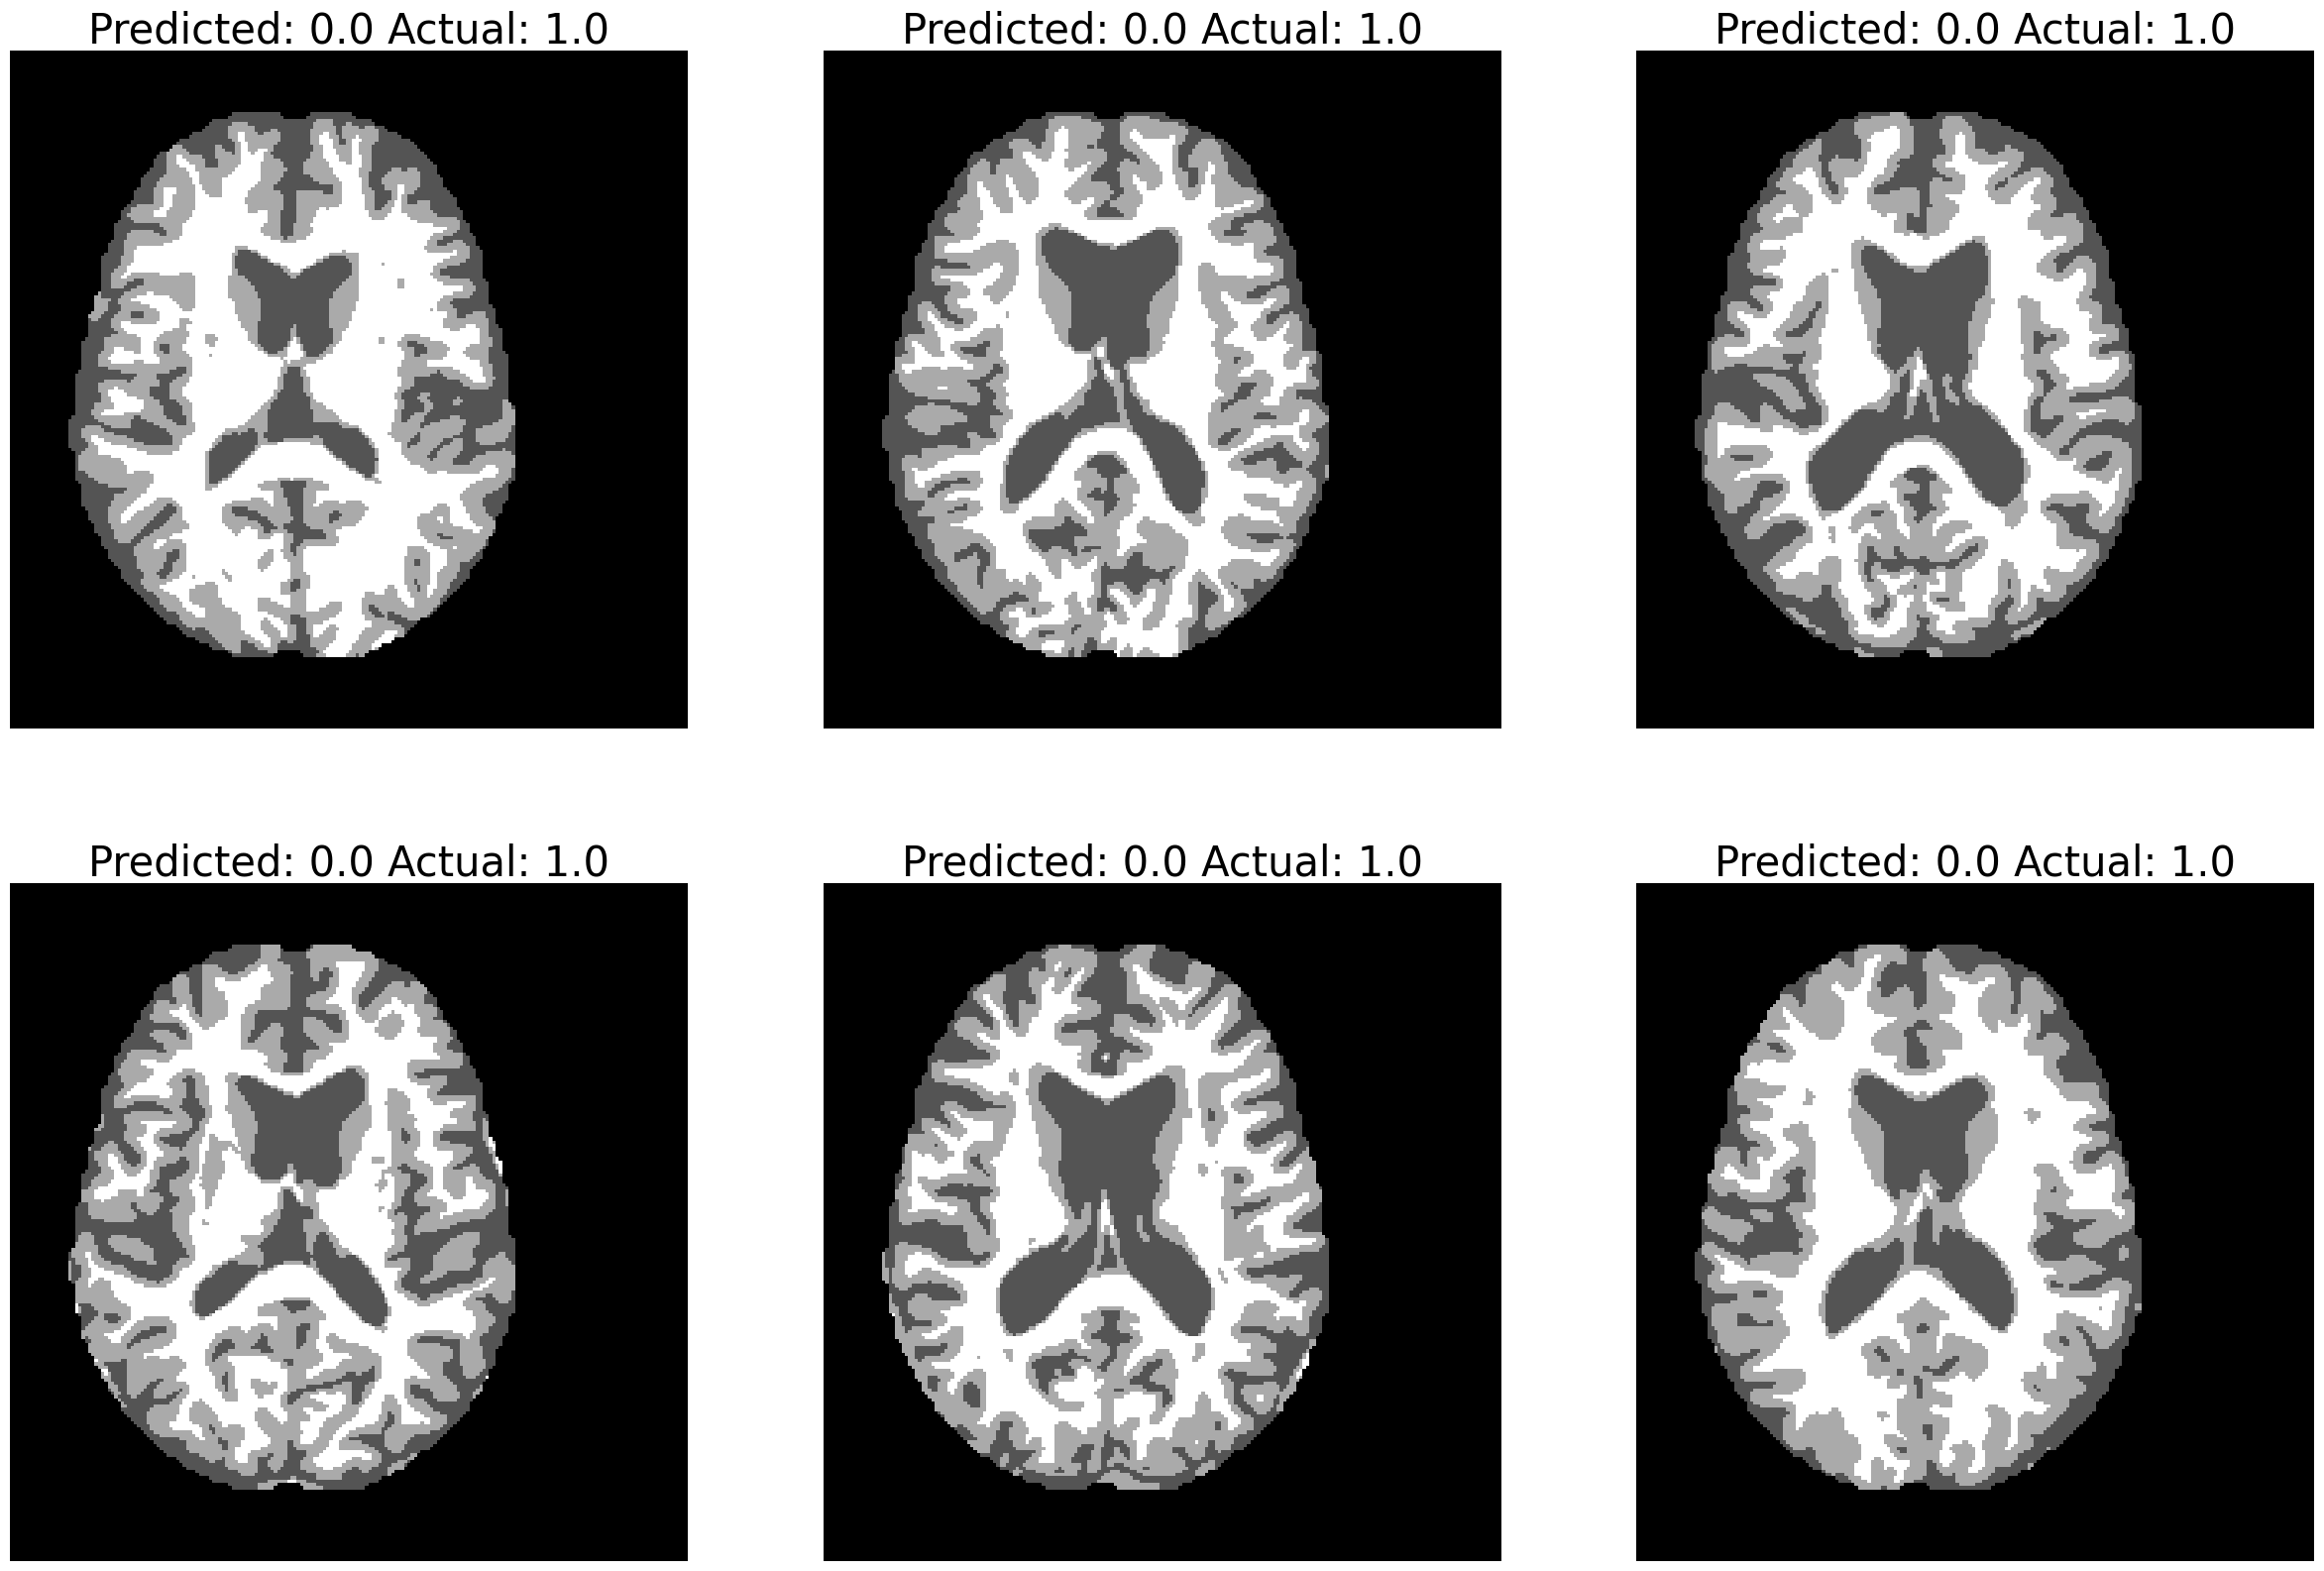

In [245]:
fig, ax = plt.subplots(2,3)
fig.set_figheight(20); fig.set_figwidth(30)
[axi.set_axis_off() for axi in ax.ravel()]


ax[0,0].imshow(img[0], cmap='gray')
ax[0,0].set_title(f'Predicted: {pred[0]} Actual: {cor[0]}', fontsize = 30)

ax[0,1].imshow(img[1], cmap='gray')
ax[0,1].set_title(f'Predicted: {pred[1]} Actual: {cor[1]}', fontsize = 30)

ax[0,2].imshow(img[2], cmap='gray')
ax[0,2].set_title(f'Predicted: {pred[2]} Actual: {cor[2]}', fontsize = 30)

ax[1,0].imshow(img[3], cmap='gray')
ax[1,0].set_title(f'Predicted: {pred[3]} Actual: {cor[3]}', fontsize = 30)

ax[1,1].imshow(img[4], cmap='gray')
ax[1,1].set_title(f'Predicted: {pred[4]} Actual: {cor[4]}', fontsize = 30)

ax[1,2].imshow(img[5], cmap='gray')
ax[1,2].set_title(f'Predicted: {pred[5]} Actual: {cor[5]}', fontsize = 30)


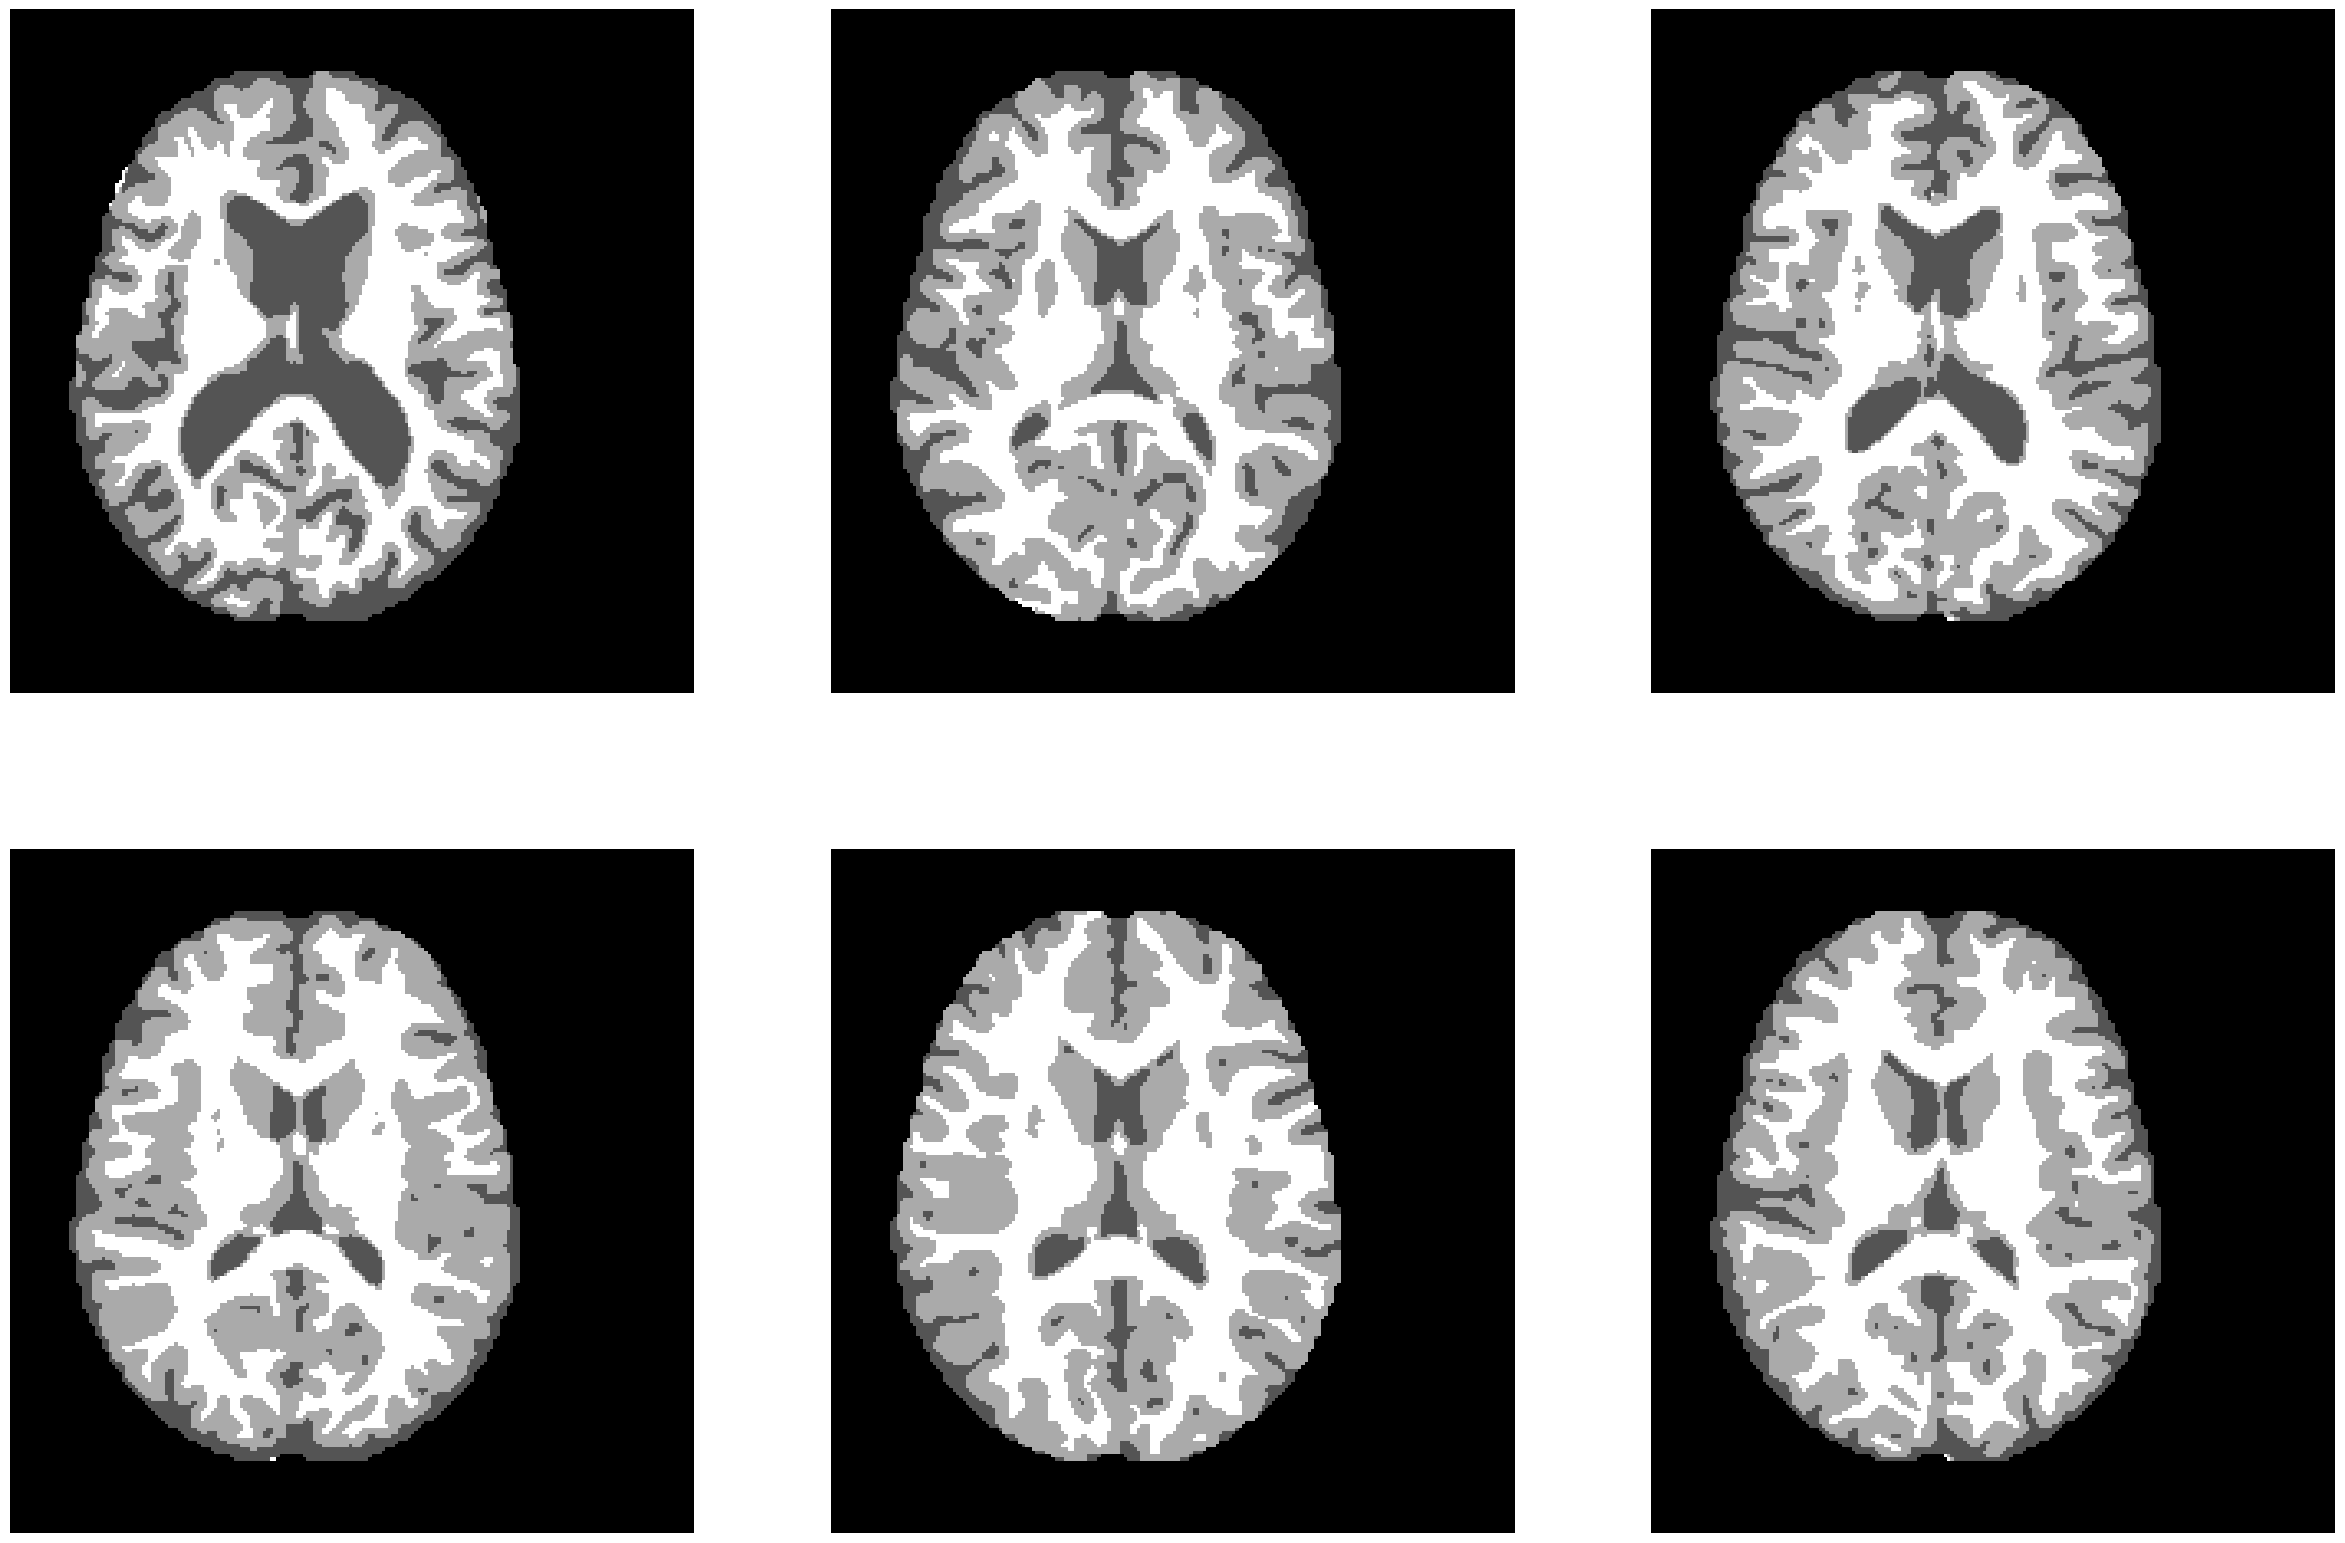

In [248]:
lst = X[T == 0][:6]
fig, ax = plt.subplots(2,3)
fig.set_figheight(20); fig.set_figwidth(30)
[axi.set_axis_off() for axi in ax.ravel()]


ax[0,0].imshow(lst[0], cmap='gray')

ax[0,1].imshow(lst[1], cmap='gray')

ax[0,2].imshow(lst[2], cmap='gray')

ax[1,0].imshow(lst[3], cmap='gray')

ax[1,1].imshow(lst[4], cmap='gray')

ax[1,2].imshow(lst[5], cmap='gray')


# Conclusion
Convolutional Neural Networks are well suited to medical imaging tasks. Going forward, it would be necessary to expand to a larger dataset. It may also be beneficial to train a network for each MRI plane. The primary difficulty in the project was getting the data into a form where it could be used, as it was not created with machine learning in mind.

# References
Daniel S. Marcus, Tracy H. Wang, Jamie Parker, John G. Csernansky, John C. Morris, Randy L. Buckner; Open Access Series of Imaging Studies (OASIS): Cross-sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults. J Cogn Neurosci 2007; 19 (9): 1498–1507. doi: https://doi.org/10.1162/jocn.2007.19.9.1498

Boysen, J. (2017, August 16). MRI and Alzheimers. Kaggle. https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers 